In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

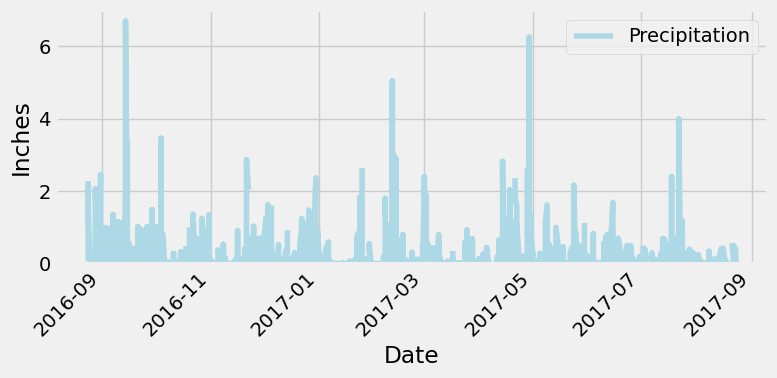

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
# Calculate the date one year from the last date in data set.
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') 
one_year_date = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_date)\
    .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])
precipitation_df = precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', kind='line', figsize=(8, 4), linestyle='-', color='lightblue')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.ylim(0, 7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()
summary_df = summary_statistics.to_frame().reset_index()
summary_df.columns = ['Statistic', 'Value']
summary_df.head(10)

,Statistic,Value
0,count,2015.000000
1,mean,0.176462
2,std,0.460288
3,min,0.000000
4,25%,0.000000
5,50%,0.020000
6,75%,0.130000
7,max,6.700000


# Exploratory Station Analysis

In [31]:
# Design a query to calculate the total number of stations in the dataset

total_stations = session.query(func.count(func.distinct(Measurement.station))).scalar()

print(total_stations)


9


In [34]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = session.query(
    Measurement.station,
    func.count(Measurement.station).label('count')
).group_by(Measurement.station)\
 .order_by(func.count(Measurement.station).desc())\
 .all()

print(most_active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [37]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_query = session.query(
    Measurement.station,
    func.count(Measurement.station).label('count')
).group_by(Measurement.station)\
 .order_by(func.count(Measurement.station).desc())\
 .first() 
most_active_station_id = most_active_station_query.station

temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station_id).one()

# Unpack the result
lowest_temp, highest_temp, avg_temp = temperature_stats

print(temperature_stats)

(54.0, 85.0, 71.66378066378067)


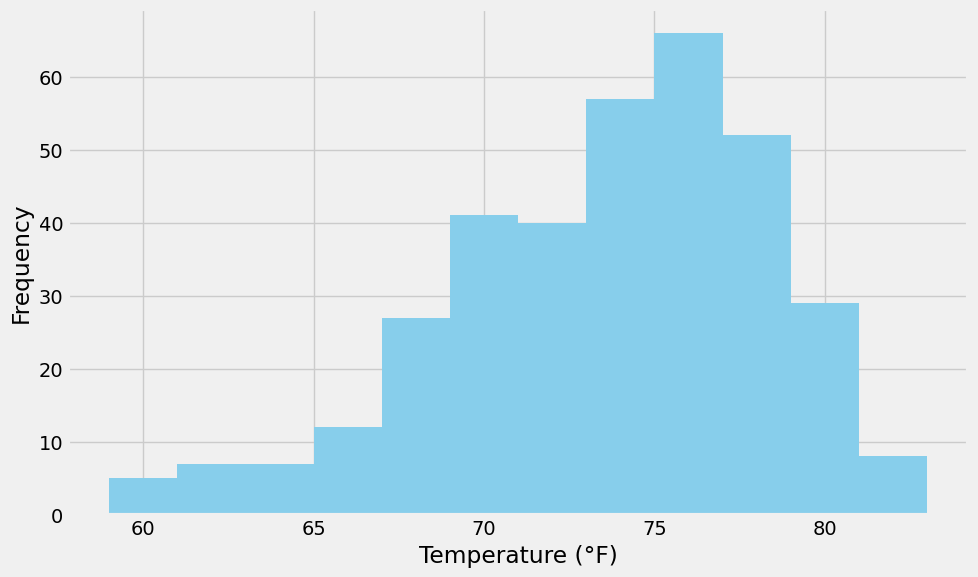

In [44]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature_data = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.station == most_active_station_id)\
    .filter(Measurement.date >= one_year_date)\
    .order_by(Measurement.date).all()



# Save the query results as a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])


# Plot the histogram of temperature observations
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['Temperature'], bins=12, color='skyblue')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


# Close Session

In [45]:
# Close Session
session.close()
